<a href="https://colab.research.google.com/github/khashayard/traffic-sign-detection/blob/main/Traffic_Signs_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!mkdir ~/.kaggle

In [5]:
mv kaggle.json ~/.kaggle

In [6]:
!kaggle datasets download pkdarabi/cardetection

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/cardetection
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/99.8M [00:00<?, ?B/s]
100% 99.8M/99.8M [00:00<00:00, 1.61GB/s]


In [7]:
!unzip --qq cardetection.zip

In [8]:
!rm -r cardetection.zip

In [9]:
ls car

data.yaml  README.dataset.txt  README.roboflow.txt  test/  train/  valid/


In [11]:
import os
import glob
import yaml

base = "car"  # مسیر پوشه دیتاست

def count_files(path):
    return len(glob.glob(path, recursive=True))

def list_stems(path, ext):
    files = glob.glob(os.path.join(path, f"*.{ext}"))
    return sorted([os.path.splitext(os.path.basename(f))[0] for f in files])

# 1. شمارش تصاویر و لیبل‌ها
print("Train images:", count_files(os.path.join(base, "train/images/*")))
print("Train labels:", count_files(os.path.join(base, "train/labels/*")))
print("Valid images:", count_files(os.path.join(base, "valid/images/*")))
print("Valid labels:", count_files(os.path.join(base, "valid/labels/*")))
print("Test images:", count_files(os.path.join(base, "test/images/*")))
print("Test labels:", count_files(os.path.join(base, "test/labels/*")))

# 2. بررسی mismatch بین تصاویر و لیبل‌ها
train_images = list_stems(os.path.join(base, "train/images"), "jpg") + \
               list_stems(os.path.join(base, "train/images"), "png")
train_labels = list_stems(os.path.join(base, "train/labels"), "txt")

mismatch = sorted(set(train_images).symmetric_difference(set(train_labels)))
if mismatch:
    print("\nMISMATCHES (train):")
    for f in mismatch:
        print(" -", f)
else:
    print("\nNo mismatches in train set ✅")

# 3. نمایش data.yaml
yaml_path = os.path.join(base, "data.yaml")
if os.path.exists(yaml_path):
    with open(yaml_path, "r") as f:
        data_yaml = f.read().splitlines()
    print("\n=== data.yaml (first 120 lines) ===")
    for line in data_yaml[:120]:
        print(line)
else:
    print("data.yaml not found")


Train images: 3530
Train labels: 3530
Valid images: 801
Valid labels: 801
Test images: 638
Test labels: 638

No mismatches in train set ✅

=== data.yaml (first 120 lines) ===
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 15
names: ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']

roboflow:
  workspace: selfdriving-car-qtywx
  project: self-driving-cars-lfjou
  version: 6
  license: CC BY 4.0
  url: https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/6


In [1]:
# !pip install -U ultralytics==8.3.0 pyyaml opencv-python
import torch, ultralytics, sys, yaml, os, shutil
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Ultralytics:", ultralytics.__version__)

PyTorch: 2.8.0+cu126
CUDA available: True
Ultralytics: 8.3.0


In [5]:
import yaml, os
from pathlib import Path

DATA_DIR = Path("/content/car")
yaml_in  = DATA_DIR / "data.yaml"
yaml_out = DATA_DIR / "data.abs.yaml"

with open(yaml_in, "r") as f:
    cfg = yaml.safe_load(f)

cfg["train"] = str((DATA_DIR / "train/images").as_posix())
cfg["val"]   = str((DATA_DIR / "valid/images").as_posix())
cfg["test"]  = str((DATA_DIR / "test/images").as_posix())

cfg["nc"]    = int(cfg["nc"])
cfg["names"] = list(cfg["names"])
# path لازم نیست چون train/val/test مطلق هستند

with open(yaml_out, "w") as f:
    yaml.safe_dump(cfg, f, allow_unicode=True, sort_keys=False)

print("✅ نوشته شد:", yaml_out)
print(open(yaml_out).read())


✅ نوشته شد: /content/car/data.abs.yaml
train: /content/car/train/images
val: /content/car/valid/images
test: /content/car/test/images
nc: 15
names:
- Green Light
- Red Light
- Speed Limit 10
- Speed Limit 100
- Speed Limit 110
- Speed Limit 120
- Speed Limit 20
- Speed Limit 30
- Speed Limit 40
- Speed Limit 50
- Speed Limit 60
- Speed Limit 70
- Speed Limit 80
- Speed Limit 90
- Stop
roboflow:
  workspace: selfdriving-car-qtywx
  project: self-driving-cars-lfjou
  version: 6
  license: CC BY 4.0
  url: https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/6



In [21]:
from ultralytics import YOLO
import torch

os.environ["WANDB_DISABLED"] = "true"

DATA  = "/content/car/data.abs.yaml"
MODEL = "yolo.pt"
EPOCHS= 100
IMGSZ = 832
BATCH = -1

model = YOLO(MODEL)

In [22]:
from ultralytics.utils import SETTINGS
SETTINGS.update({'wandb': False})


In [24]:
from ultralytics import YOLO
import torch

DATA  = "/content/car/data.abs.yaml"
MODEL = "yolo11s.pt"
EPOCHS= 100
IMGSZ = 832
BATCH = -1

model = YOLO(MODEL)
results = model.train(
    data=DATA,
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    seed=42,
    cos_lr=True,
    device=0 if torch.cuda.is_available() else None,
    workers=2
)


New https://pypi.org/project/ultralytics/8.3.203 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.0 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/car/data.abs.yaml, epochs=100, time=None, patience=100, batch=-1, imgsz=832, save=True, save_period=-1, cache=False, device=0, workers=2, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: khashayard9 (khashayard9-academia-edu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 224MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=832 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA A100-SXM4-80GB) 79.32G total, 0.12G reserved, 0.11G allocated, 79.08G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     9433597       36.47         0.575         41.43          1120        (1, 3, 832, 832)                    list
     9433597       72.94         1.002          25.8          1061        (2, 3, 832, 832)                    list
     9433597       145.9         1.825         27.08          1076        (4, 3, 832, 832)                    list
     9433597       291.7         3.519         27.83          1063        (8, 3, 832, 832)                    list
     9433597       583.5         6.898         37.68          1085       (16, 3, 832, 832)                    list
AutoBatch: Using batch-size 112 for CUDA:0 47.59G/79.32G (60%) ✅


train: Scanning /content/car/train/labels... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:02<00:00, 1488.21it/s]


train: New cache created: /content/car/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/car/valid/labels... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<00:00, 1407.51it/s]

val: New cache created: /content/car/valid/labels.cache


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.000875), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 832 train, 832 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100        48G      1.103      5.659       1.46        135        832: 100%|██████████| 32/32 [00:54<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.75s/it]

                   all        801        944      0.254      0.504      0.287      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      47.9G     0.7228      2.224      1.147        133        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        801        944      0.368      0.408      0.375      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      47.8G     0.7532      1.552       1.15        128        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        801        944      0.501      0.437      0.415      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      47.9G     0.7426      1.307       1.15        104        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        801        944      0.606      0.396      0.464      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      47.9G     0.7149       1.16       1.13        150        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        801        944      0.639      0.463      0.498      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      47.9G     0.7038       1.04      1.123        119        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.636      0.618       0.68      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      47.9G     0.6953     0.9754      1.119        128        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        801        944      0.737      0.694      0.801      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100        48G     0.6813      0.942      1.107        121        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.806      0.735      0.824      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      47.8G     0.6707     0.9204      1.099        131        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        801        944      0.801       0.76      0.837      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      47.8G     0.6768      0.881      1.101        157        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.799      0.777       0.86      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      47.8G     0.6503     0.8422      1.081        137        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        801        944      0.846      0.753      0.833      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      47.9G      0.651     0.8089       1.09        118        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.845      0.801      0.886      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      48.1G     0.6441     0.8115      1.087        133        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        801        944      0.884      0.815      0.908      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      47.8G      0.627       0.76      1.068        137        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.862      0.821      0.895      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      47.8G     0.6356     0.7838      1.075        146        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.918       0.83       0.93      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      47.9G     0.6464     0.7634      1.077        116        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.914      0.805      0.912      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      47.9G     0.6215     0.7294      1.064        120        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.932      0.826      0.928      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      47.9G     0.6032     0.6989      1.057        150        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.919      0.843      0.932      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      47.9G     0.6113     0.7099      1.057        130        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944       0.94      0.849      0.924      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      47.9G     0.6089     0.6968      1.057        115        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944       0.93      0.837      0.931      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      47.9G     0.6136     0.6925      1.053        139        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.909      0.845      0.931      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      47.9G     0.6083     0.6717      1.053        123        832: 100%|██████████| 32/32 [00:38<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        801        944      0.899      0.897      0.938      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      47.8G     0.6009      0.671      1.048        121        832: 100%|██████████| 32/32 [00:38<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944       0.93       0.88      0.941      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      47.9G     0.5986     0.6591       1.05        143        832: 100%|██████████| 32/32 [00:38<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        801        944      0.929      0.898      0.951      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      47.9G     0.5981     0.6568      1.049        133        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944       0.92      0.871      0.942      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100        48G     0.5863     0.6344       1.04        126        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        801        944      0.926      0.899       0.95      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      47.8G      0.596     0.6316      1.044        120        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.918      0.898      0.952      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      47.9G     0.5888     0.6113       1.04        117        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.938      0.911      0.956      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      47.9G      0.581     0.6137      1.035        125        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.937      0.913      0.959      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      47.9G     0.5703     0.6093      1.031        127        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.948      0.907       0.96      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      47.9G     0.5723     0.5994      1.029        135        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.929      0.905      0.955      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      47.8G     0.5778      0.582      1.032        134        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.945       0.92       0.96      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      47.8G     0.5667     0.5807      1.024        123        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.915      0.907      0.959      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      47.8G     0.5632     0.5674      1.022        121        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.942      0.925      0.968      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      47.9G     0.5666     0.5733      1.034        126        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        801        944      0.955       0.91      0.962      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      47.8G     0.5716     0.5729      1.023        140        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.949      0.894       0.96      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      47.9G     0.5514     0.5485      1.018        157        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.924      0.931      0.965      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      47.9G     0.5584     0.5575      1.021        147        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.936      0.923      0.958      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      47.9G      0.552     0.5539      1.023        126        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.941      0.933      0.966      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      47.9G     0.5513     0.5529      1.017        144        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.954      0.912      0.965      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      47.8G     0.5469     0.5417      1.012        116        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.941      0.919      0.963      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      47.9G     0.5415     0.5342      1.013        124        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.941      0.926      0.967      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      47.8G     0.5401     0.5216      1.013        118        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.951      0.935      0.968      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      47.8G     0.5384     0.5176      1.008        128        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.945      0.924      0.965      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      47.8G      0.532     0.5066      1.013        136        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.953      0.936      0.969      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      47.9G     0.5276      0.508      1.006        131        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.955      0.918      0.968      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      47.9G     0.5335     0.5056      1.005        151        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.938      0.942      0.971      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      47.8G     0.5278     0.4976      1.002        152        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944       0.94      0.934      0.969      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      47.9G      0.531     0.5028      1.003        130        832: 100%|██████████| 32/32 [00:37<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        801        944      0.944      0.936      0.966      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      47.9G     0.5282     0.5015      1.005        115        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.946      0.927      0.968      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      47.8G     0.5189     0.4935     0.9962        143        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.955      0.926      0.964       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      48.1G     0.5117     0.4786     0.9976        139        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.971       0.92      0.973      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      47.9G     0.5133     0.4716     0.9938        140        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.957      0.933      0.972      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      47.9G     0.5208     0.4855     0.9948        112        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.961      0.945      0.971       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      47.9G     0.5121     0.4668     0.9979        114        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        801        944      0.963      0.937       0.97      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      47.8G      0.502     0.4661     0.9978        126        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.958      0.946      0.972      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      47.9G     0.5064     0.4592      0.989        133        832: 100%|██████████| 32/32 [00:37<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.957      0.936       0.97      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      47.9G     0.4915     0.4507     0.9837        133        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.948       0.95      0.974      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      48.1G     0.4995     0.4586     0.9832        124        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.951      0.952      0.973      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      47.9G     0.4948     0.4427     0.9883        124        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        801        944      0.967      0.937      0.973      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      47.8G     0.4957     0.4556     0.9816        136        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.948      0.949      0.972      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100        48G     0.4849     0.4352     0.9811        120        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.965      0.942      0.975      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      47.9G     0.4882     0.4208     0.9736        136        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944       0.96      0.941      0.975      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      47.9G     0.4831     0.4177     0.9792        110        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.962      0.945      0.976      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      47.9G     0.4776     0.4286     0.9737        125        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.953      0.948      0.976      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      47.8G     0.4822     0.4284     0.9773        129        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.953      0.955      0.977      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      48.1G     0.4811     0.4277     0.9769        150        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.962      0.945      0.972      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      47.8G     0.4734     0.4206     0.9781        105        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.957      0.949      0.973      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      47.9G     0.4819     0.4198     0.9799        122        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.969      0.952      0.977      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      47.9G     0.4598      0.401       0.97        111        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.969      0.962      0.978      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      48.1G     0.4683     0.4013     0.9713        131        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.961      0.946      0.975      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      47.8G     0.4572     0.3997     0.9728        139        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.966      0.946      0.975      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      47.8G     0.4653     0.3968     0.9702        111        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.959      0.953      0.975      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      47.8G     0.4617     0.3899     0.9662        130        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.966      0.948      0.976      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      47.9G     0.4562     0.3817     0.9661        122        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944       0.96      0.944      0.977      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      47.9G     0.4607     0.3803     0.9614        138        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.967      0.955      0.977      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100        48G     0.4543     0.3842     0.9614        124        832: 100%|██████████| 32/32 [00:37<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944       0.97      0.946      0.975      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      47.9G     0.4496     0.3771     0.9602        138        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.968      0.939      0.975      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      47.9G     0.4491     0.3806     0.9618        131        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.968      0.948      0.973      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      47.9G     0.4485       0.37     0.9592        136        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        801        944      0.973      0.943      0.973      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      48.1G      0.448     0.3745     0.9637        118        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.963      0.947      0.971      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      47.8G     0.4442     0.3671     0.9554        136        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.972       0.94      0.972      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      47.8G      0.441       0.37     0.9564        138        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.966      0.945      0.973      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      47.9G     0.4378      0.366     0.9553        105        832: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all        801        944      0.968      0.939      0.973      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      47.9G       0.44     0.3626     0.9543        130        832: 100%|██████████| 32/32 [00:37<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.964      0.941      0.971      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      47.8G      0.441     0.3625     0.9562        116        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.972      0.945      0.972      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      47.8G     0.4284     0.3576      0.952        125        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        801        944      0.972      0.946      0.973      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      48.1G     0.4335     0.3541     0.9504        128        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944       0.97      0.944      0.973      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      47.8G     0.4279      0.361      0.949        130        832: 100%|██████████| 32/32 [00:36<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.967      0.943      0.973      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      47.9G     0.4354     0.3658     0.9531        123        832: 100%|██████████| 32/32 [00:37<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        801        944      0.968      0.944      0.973      0.854


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      47.8G     0.4485     0.2476     0.9267         63        832: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.969      0.945      0.972      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      47.8G     0.4401     0.2391     0.9231         72        832: 100%|██████████| 32/32 [00:33<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.969       0.94      0.972      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      47.8G     0.4351     0.2401     0.9229         62        832: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.967      0.934      0.972       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      48.1G     0.4361     0.2398     0.9273         72        832: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

                   all        801        944       0.96      0.942      0.972      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      47.8G     0.4349     0.2377     0.9214         67        832: 100%|██████████| 32/32 [00:33<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.964      0.939      0.972      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      47.8G     0.4313     0.2371     0.9219         84        832: 100%|██████████| 32/32 [00:33<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.955      0.946      0.973      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      47.8G     0.4305     0.2383     0.9184         69        832: 100%|██████████| 32/32 [00:33<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.961      0.941      0.972      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      47.8G     0.4298     0.2368     0.9177         65        832: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        801        944      0.956      0.944      0.972      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      47.8G     0.4312     0.2357     0.9196         66        832: 100%|██████████| 32/32 [00:33<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        801        944      0.964      0.943      0.973      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      47.8G     0.4282     0.2383      0.916         67        832: 100%|██████████| 32/32 [00:33<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        801        944      0.965      0.944      0.972      0.854



100 epochs completed in 1.169 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 19.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.0 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
YOLO11s summary (fused): 238 layers, 9,418,605 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


                   all        801        944      0.964      0.942      0.975      0.856
           Green Light         87        122      0.937      0.762      0.907      0.581
             Red Light         74        108      0.896      0.778      0.863       0.57
       Speed Limit 100         52         52      0.993          1      0.995      0.919
       Speed Limit 110         17         17      0.952      0.882      0.963      0.906
       Speed Limit 120         60         60      0.983       0.99      0.995      0.925
        Speed Limit 20         56         56      0.983      0.982      0.993      0.878
        Speed Limit 30         71         74      0.948      0.995      0.994      0.918
        Speed Limit 40         53         55       0.93      0.982      0.993       0.89
        Speed Limit 50         68         71      0.956      0.972      0.987      0.899
        Speed Limit 60         76         76      0.974      0.967      0.986      0.896
        Speed Limit 7

lr/pg0,▃█████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
lr/pg1,▃██████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
lr/pg2,▃███████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
metrics/mAP50(B),▁▄▆▆▇▇▇▇████████████████████████████████
metrics/mAP50-95(B),▁▂▂▃▄▅▆▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
metrics/precision(B),▁▃▄▄▇▇█▇▇█████▇█████████████████████████
metrics/recall(B),▂▁▂▅▅▆▅▆▇▆▇▇▇▇▇▇▇▇█▇▇██▇████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


In [25]:
model.val(
    data=DATA,
    imgsz=IMGSZ,
    conf=0.001,
    iou=0.6,
    plots=True)


Ultralytics 8.3.0 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
YOLO11s summary (fused): 238 layers, 9,418,605 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /content/car/valid/labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


                   all        801        944      0.961      0.945      0.976      0.856
           Green Light         87        122      0.915      0.762       0.91      0.573
             Red Light         74        108      0.887      0.801      0.866       0.57
       Speed Limit 100         52         52      0.992          1      0.995      0.916
       Speed Limit 110         17         17      0.948      0.882      0.963      0.901
       Speed Limit 120         60         60      0.983      0.993      0.995      0.929
        Speed Limit 20         56         56      0.981      0.982      0.993      0.879
        Speed Limit 30         71         74      0.949          1      0.994      0.922
        Speed Limit 40         53         55      0.925      0.982      0.993      0.887
        Speed Limit 50         68         71      0.954      0.972      0.987      0.896
        Speed Limit 60         76         76      0.974      0.971      0.986      0.893
        Speed Limit 7

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b4b0a5a7d40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [27]:
from ultralytics import YOLO
model = YOLO("runs/detect/train5/weights/best.pt")
model.export(format="onnx", opset=12)

Ultralytics 8.3.0 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
YOLO11s summary (fused): 238 layers, 9,418,605 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'runs/detect/train5/weights/best.pt' with input shape (1, 3, 832, 832) BCHW and output shape(s) (1, 19, 14196) (18.3 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim==0.1.34', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 254.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 338.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 14.6s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim==0.1.34', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rer

'runs/detect/train5/weights/best.onnx'

In [28]:
import shutil
from google.colab import files

src = "runs/detect/train5/weights/best.onnx"


dst = "traffic_detect.onnx"
shutil.copy(src, dst)

files.download(dst)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
files.download('runs/detect/train5/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


0: 832x832 1 Speed Limit 120, 15.0ms
1: 832x832 2 Green Lights, 15.0ms
2: 832x832 1 Speed Limit 110, 15.0ms
3: 832x832 2 Red Lights, 15.0ms
4: 832x832 1 Speed Limit 40, 1 Stop, 15.0ms
5: 832x832 1 Speed Limit 100, 1 Speed Limit 120, 15.0ms
Speed: 4.9ms preprocess, 15.0ms inference, 1.1ms postprocess per image at shape (1, 3, 832, 832)


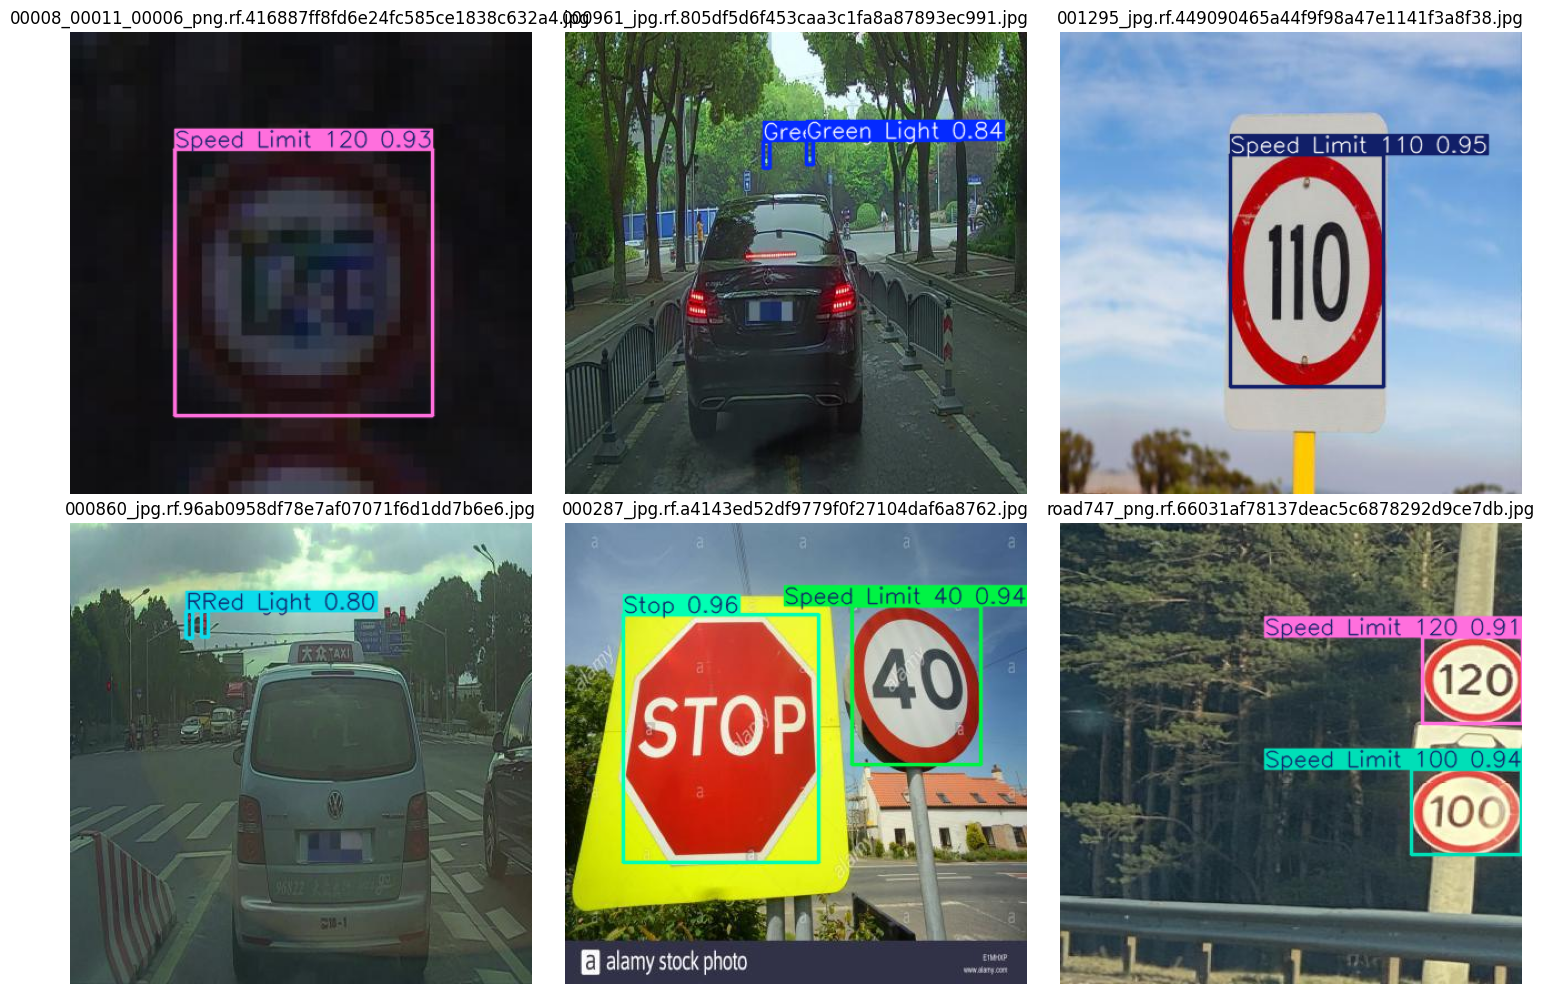

In [50]:

import matplotlib.pyplot as plt
import glob, os, random


BEST_PT  = "runs/detect/train5/weights/best.pt"
TEST_DIR = "/content/car/test/images"
IMGSZ    = 832
CONF     = 0.25


exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
img_paths = []
for e in exts:
    img_paths += glob.glob(os.path.join(TEST_DIR, e))
assert img_paths, f"هیچ تصویری در {TEST_DIR} پیدا نشد."
random.seed(0)
sample_imgs = random.sample(img_paths, min(6, len(img_paths)))




results = model.predict(source=sample_imgs, imgsz=IMGSZ, conf=CONF, save=False)


plt.figure(figsize=(15, 10))
for i, r in enumerate(results):
    plt.subplot(2, 3, i+1)

    im_bgr = r.plot()
    im_rgb = im_bgr[..., ::-1]
    plt.imshow(im_rgb)
    plt.axis("off")
    plt.title(os.path.basename(sample_imgs[i]))
plt.tight_layout()
plt.show()


In [70]:
!wget "https://traffickala.com/wp-content/uploads/2022/05/panel-maximum-speed-traffickalacom1.webp" -O img3.png


--2025-09-25 03:29:25--  https://traffickala.com/wp-content/uploads/2022/05/panel-maximum-speed-traffickalacom1.webp
Resolving traffickala.com (traffickala.com)... 148.251.116.174
Connecting to traffickala.com (traffickala.com)|148.251.116.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177828 (174K) [image/webp]
Saving to: ‘img3.png’

img3.png            100%[===================>] 173.66K  --.-KB/s    in 0.04s   

2025-09-25 03:29:25 (4.48 MB/s) - ‘img3.png’ saved [177828/177828]




image 1/1 /content/img3.png: 832x832 2 Speed Limit 80s, 1 Speed Limit 90, 11.9ms
Speed: 5.4ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 832, 832)


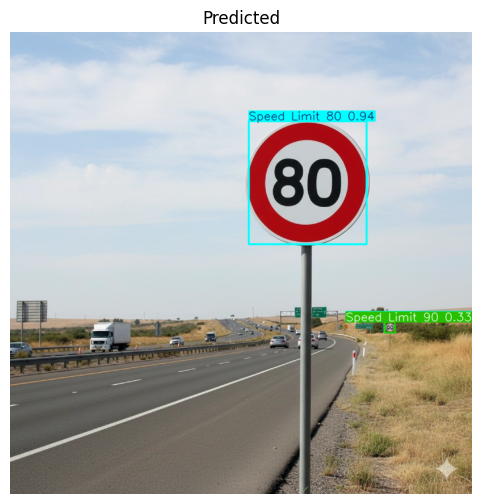

In [72]:
IMG_PATH = "img3.png"



res = model.predict(source=IMG_PATH, conf=0.25, imgsz=832, save=False)

plt.figure(figsize=(6,6))
im_bgr = res[0].plot()      # تصویر با باکس‌ها (BGR)
im_rgb = im_bgr[..., ::-1]  # تبدیل به RGB
plt.imshow(im_rgb)
plt.axis("off")
plt.title("Predicted")
plt.show()
